### Representational Power, Deep Rectifier Networks


We have already seen that all logic functions can be reprensented functionally as a feedforward neural network.
Here, we consider the capacity of deep rectifier networks to partition the input domain into linear regions.

The result we consider is from Mont&uacute;far et al.: *On the number of linear regions of deep neural networks* (2014).

**Theorems.**

(1) The maximal number of linear regions of the functions computed by any rectifier network with a total of $N$ hidden units is bounded from above by $2^N$.

(2) The maximal number of linear regions of the functions computed by any rectifier network with $n_0$ input units and $L$ hidden layers, with $n_i \geq n_0$ rectifiers at the $i$th layer, is lower bounded by
$$ \big( \prod_{i=1}^{L-1} \left\lfloor \frac{n_i}{n_0} \right\rfloor^{n_0} \big) \; \sum_{j=0}^{n_0} \binom{n_L}{j} $$

In [8]:
# Import some stuff...
import numpy as np
#
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'family':'Times New Roman', 'weight':'normal', 'size':10})
import matplotlib.pyplot as plt

So, what is the lower bound when $n_i$ is fixed for $i>0$?

In [61]:
def lower_bound(ni,n0,L):
    """
    n0 : input dimension
    ni : hidden & output dimension
    """
    ni, n0, L = int(ni), int(n0), int(L) 
    assert ni >= n0
    from scipy.misc import comb as nchoosek       
    factor1 = np.floor(ni / n0)**(n0 * (L-1.))
    factor2 = np.sum([nchoosek(ni,j) for j in range(n0+1)])
    return factor1 * factor2

In [78]:
n0 = 2
num_layers = range(1,4)
num_hidden = range(2,11)

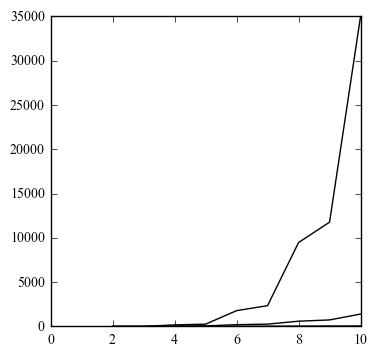

In [79]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
for L in num_layers:
    lb = [lower_bound(ni,n0,L) for ni in num_hidden]
    plt.plot(num_hidden,lb,color='black',linestyle='-',linewidth=1.)
plt.xlim([0,10])
plt.show()

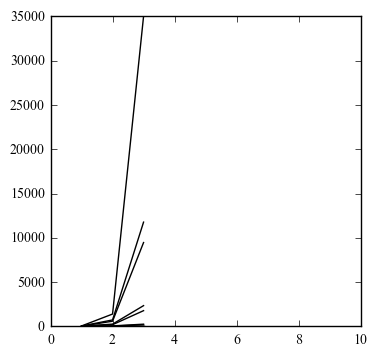

In [80]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
for ni in num_hidden:
    lb = [lower_bound(ni,n0,L) for L in num_layers]
    plt.plot(num_layers,lb,color='black',linestyle='-',linewidth=1.)
plt.xlim([0,10])
plt.show()

In [2]:
ng = 4   # the number of checks along a dimension
t = np.linspace(0,1,ng+1)

In [3]:
X = np.random.uniform(0,1,size=(1000,2))

In [4]:
Y = np.sum(np.floor(X*ng),axis=1) % 2
Y = np.vstack([Y, 1.-Y]).T   # have 2-dimensions for cross-entropy in neural net

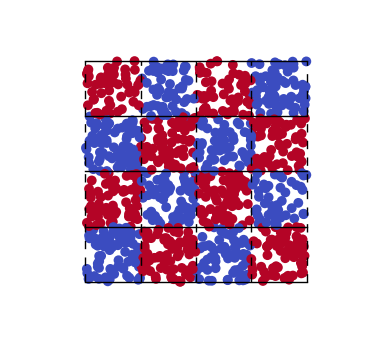

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
for s in t:
    plt.plot(s*np.ones_like(t),t,color='black',linestyle='--',linewidth=1.)
    plt.plot(t,s*np.ones_like(t),color='black',linestyle='-',linewidth=1.)
plt.scatter(X[:,0],X[:,1],s=50,c=Y[:,0],edgecolors='',cmap=plt.cm.coolwarm)
plt.axis('equal')
plt.axis('off')
plt.show()

In [6]:
import tensorflow as tf

In [7]:
def fc_layer(incoming, size_in, size_out, name="fc"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        act = tf.nn.relu(tf.matmul(incoming, w) + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act

In [8]:
tf.reset_default_graph()
sess = tf.Session()

In [9]:
# Setup placeholders
x = tf.placeholder(tf.float32, shape=[None, 2], name="x")
y = tf.placeholder(tf.float32, shape=[None, 2], name="labels")

In [10]:
fc1 = fc_layer(x, 2, 128, 'fc1')
fc2 = fc_layer(fc1, 128, 128, 'fc2')
fc3 = fc_layer(fc2, 128, 128, 'fc3')
logits = fc_layer(fc3, 128, 2, 'fc4')

In [11]:
# look at variables
for v in tf.trainable_variables():
    print(v.name)
    if 'W' in v.name.split('/')[1]:
        print('-'*10, v)

fc1/W:0
---------- Tensor("fc1/W/read:0", shape=(2, 128), dtype=float32)
fc1/B:0
fc2/W:0
---------- Tensor("fc2/W/read:0", shape=(128, 128), dtype=float32)
fc2/B:0
fc3/W:0
---------- Tensor("fc3/W/read:0", shape=(128, 128), dtype=float32)
fc3/B:0
fc4/W:0
---------- Tensor("fc4/W/read:0", shape=(128, 2), dtype=float32)
fc4/B:0


In [12]:
with tf.name_scope("loss"):
    xent = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, labels=y), name="xent")
    regL2 = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()
                         if 'W' in v.name.split('/')[1]], name="regL2") 
    loss = xent + 1e-3 * regL2
    tf.summary.scalar("xent", xent)
    tf.summary.scalar("loss", loss)
    
with tf.name_scope("train"):
    learning_rate = 1e-3
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

summ = tf.summary.merge_all()    

In [13]:
saver = tf.train.Saver()

In [14]:
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('/tmp/checkerboardd/2')
writer.add_graph(sess.graph)

In [15]:
test0 = [tf.nn.l2_loss(v) for v in tf.trainable_variables()]
test1 = tf.add_n(test0)
test2 = tf.reduce_mean(test0)    # we don't want the mean over the final L2 norms; but over total number of weight values!
a0, a1, a2 = sess.run([test0, test1, test2])
print(a1, a2)
print(np.sum(a0), np.mean(a0))

131.544 16.443
131.544 16.443


In [16]:
import os

In [17]:
num_steps = 10000
batch_size = 128

for step in range(num_steps):
    offset = (step * batch_size) % X.shape[0]
    # Generate a minibatch.
    batch_data = X[offset:(offset + batch_size), :]
    batch_labels = Y[offset:(offset + batch_size), :]
    if step % 5 == 0:
        [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: batch_data, y: batch_labels})
        writer.add_summary(s, step)        
    if step % 500 == 0:
        print("Minibatch accuracy: %.2f" % train_accuracy)
        saver.save(sess, os.path.join('/tmp/checkerboardd', "model.ckpt"), step)
    sess.run(train_step, feed_dict={x: batch_data, y: batch_labels})

Minibatch accuracy: 0.46
Minibatch accuracy: 0.59
Minibatch accuracy: 0.72
Minibatch accuracy: 0.74
Minibatch accuracy: 0.75
Minibatch accuracy: 0.77
Minibatch accuracy: 0.77
Minibatch accuracy: 0.77
Minibatch accuracy: 0.78
Minibatch accuracy: 0.85
Minibatch accuracy: 0.91
Minibatch accuracy: 0.91
Minibatch accuracy: 0.93
Minibatch accuracy: 0.93
Minibatch accuracy: 0.95
Minibatch accuracy: 0.98
Minibatch accuracy: 0.95
Minibatch accuracy: 0.95
Minibatch accuracy: 0.98
Minibatch accuracy: 0.98


In [18]:
decision_values, predicted = sess.run([logits, tf.nn.softmax(logits)], feed_dict={x: X})

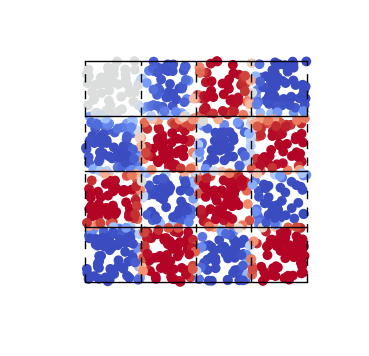

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
for s in t:
    plt.plot(s*np.ones_like(t),t,color='black',linestyle='--',linewidth=1.)
    plt.plot(t,s*np.ones_like(t),color='black',linestyle='-',linewidth=1.)
plt.scatter(X[:,0],X[:,1],s=50,c=predicted[:,0],edgecolors='',cmap=plt.cm.coolwarm)
plt.axis('equal')
plt.axis('off')
plt.show()